In [1]:
import sys
sys.path.append("/kaggle/input/kaggle-utils")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# %run ../utils/stat_funcs.py
%run /kaggle/input/kaggle-utils/stat_funcs.py
print("custom functions are now available in the notebook namespace!")

print("Libraries loaded successfully!")

custom functions are now available in the notebook namespace!
Libraries loaded successfully!


In [2]:
# train_df = pd.read_csv("../data-raw/train.csv")
# test_df = pd.read_csv("../data-raw/test.csv")

train_df = pd.read_csv("/kaggle/input/playground-series-s6e1/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s6e1/test.csv")

## Data Exploration

Target column: `exam_score`

In [3]:
train_df.head(10)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0
5,5,24,male,b.com,5.04,85.1,yes,9.4,average,online videos,medium,moderate,70.1
6,6,20,male,b.sc,4.28,87.0,no,9.1,average,mixed,high,moderate,63.4
7,7,22,female,ba,4.19,44.9,yes,8.8,good,self-study,high,hard,76.8
8,8,22,other,b.com,1.06,98.3,yes,5.0,poor,mixed,low,moderate,46.7
9,9,18,male,bba,3.44,80.9,yes,6.2,good,group study,medium,easy,58.2


Missing values

In [4]:
train_df.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

Data Types

In [5]:
train_df.dtypes

id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

In [6]:
for col in ["gender", "course", "internet_access", "sleep_quality", "study_method", "facility_rating", "exam_difficulty"]:
  train_df[col] = train_df[col].astype('category')

train_df.dtypes

id                     int64
age                    int64
gender              category
course              category
study_hours          float64
class_attendance     float64
internet_access     category
sleep_hours          float64
sleep_quality       category
study_method        category
facility_rating     category
exam_difficulty     category
exam_score           float64
dtype: object

Statistical Summary

In [7]:
train_df.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


Missing Values

In [8]:
print(train_df.isnull().sum())

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64


## What do we got?

### Averages

- 20.5 year old students,
- who studies for 4 hours, and
- are in class ~71.9% of the time.
- They sleep about 7 hours,
- and score about ~62.5%.

### Extremes

- We have students who are as young as 17 years and as old as 24 years.
- Some students study for only 0.08 hours?! while others study for 8 hours.
- We have some who are almost in all classes and others who are present only ~40% of the time.
- Lowest exam score is 19.5% and the highest is 100%.

### Other
- No missing values in any variables

## Exam Score Analysis

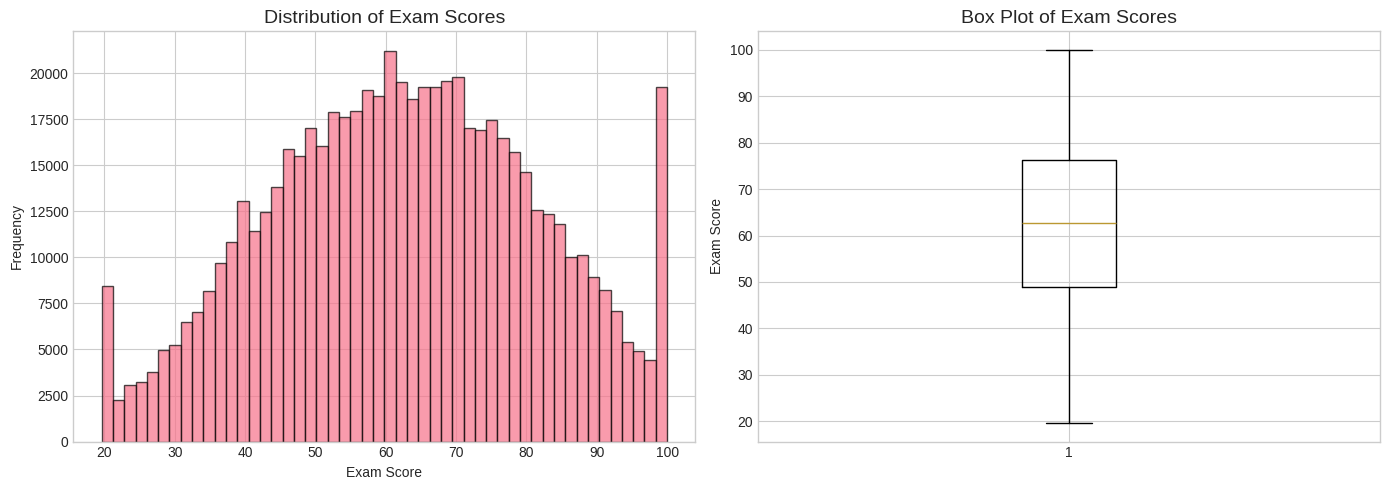

In [9]:
## Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['exam_score'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Exam Scores', fontsize=14)
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')

# Box plot
axes[1].boxplot(train_df['exam_score'], vert=True)
axes[1].set_title('Box Plot of Exam Scores', fontsize=14)
axes[1].set_ylabel('Exam Score')

plt.tight_layout()
plt.show()

In [10]:
print(f"Mean:   {train_df['exam_score'].mean():.2f}")
print(f"Median: {train_df['exam_score'].median():.2f}")
print(f"Std:    {train_df['exam_score'].std():.2f}")

Mean:   62.51
Median: 62.60
Std:    18.92


## Categorical Feature Analysis (univariate analysis)

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Gender vs Exam Scores

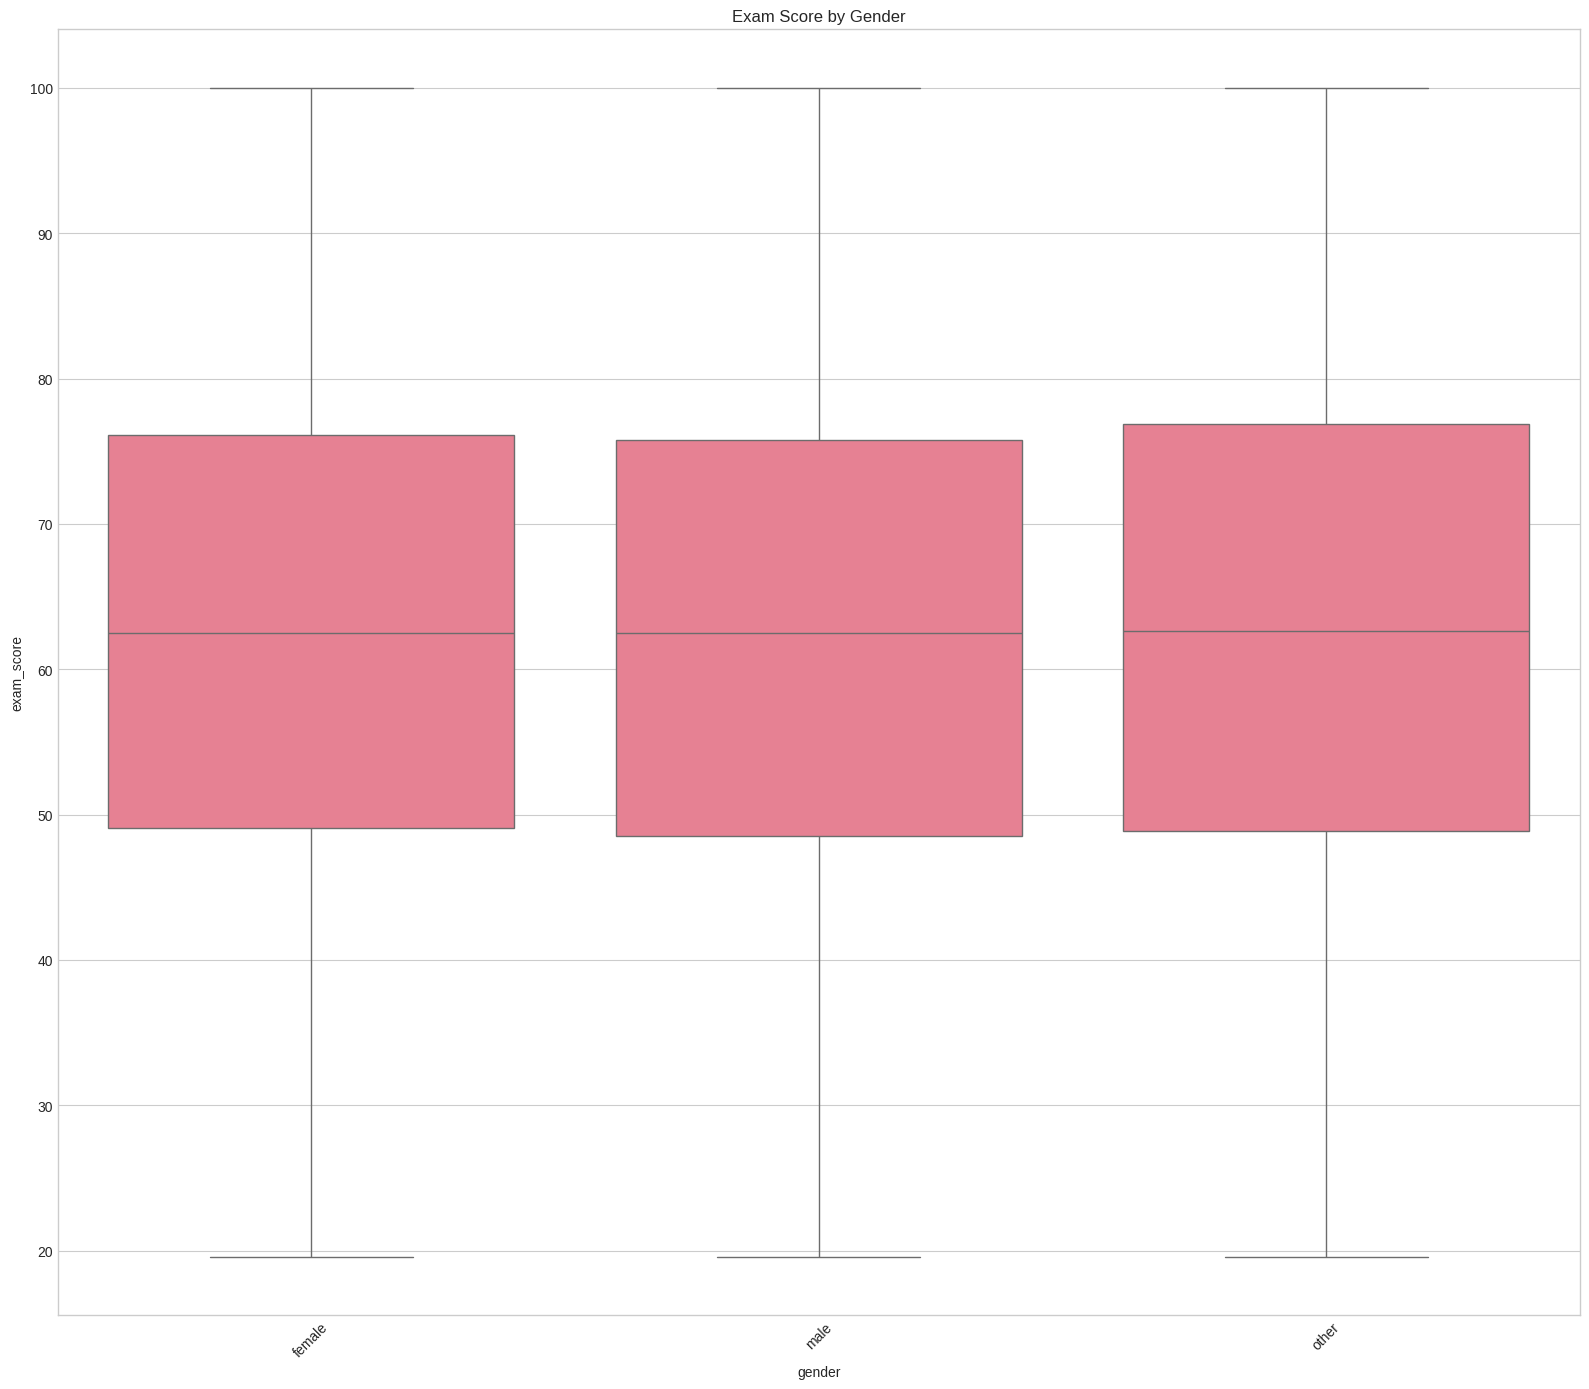

In [12]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='gender', y='exam_score', ax=ax)
ax.set_title('Exam Score by Gender', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
summary = (
    train_df.groupby("gender")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

             n       mean  median        std    q1    q3
gender                                                  
female  208310  62.563220    62.5  18.891115  49.1  76.1
male    210593  62.175561    62.5  18.765553  48.5  75.8
other   211097  62.781191    62.6  19.087020  48.9  76.9


One-way ANOVA via Ordinary Least Squares

In [14]:
df = train_df.dropna(subset=["exam_score", "gender"]).copy()

model = smf.ols("exam_score ~ C(gender)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

Eta-squared = SS_between / SS_total

In [15]:
ss_between = anova_table.loc["C(gender)", "sum_sq"]
ss_resid = anova_table.loc["Residual", "sum_sq"]
ss_total = ss_between + ss_resid
eta_sq = ss_between / ss_total

In [16]:
print(anova_table)
print(f"\nEta-squared (η^2): {eta_sq:.6f}")

                 sum_sq        df          F        PR(>F)
C(gender)  3.966275e+04       2.0  55.427932  8.512806e-25
Residual   2.254045e+08  629997.0        NaN           NaN

Eta-squared (η^2): 0.000176


- **ANOVA result:** (F(`2`, `629,997`)=`55.43`), (`p`~ `8.5e-25`).
  - With a sample this large, **at least one gender group mean differs from another** in a statistically detectable way.
- **Effect size (η^2 = 0.000176):** This is the key interpretation for “how big.”
  - eta^2 is the **proportion of total variation in exam scores explained by gender**.
  - eta^2 = 0.000176 ~ 0.0176%

So **gender explains about 0.018% of the variance** in exam scores - essentially none in practical terms.

Even though the p-value is tiny (because we have ~630k rows), **gender is not meaningfully related to exam score** in terms of how much it helps explain or predict scores. The group means may differ by a small amount, but the difference is **very small relative to the overall spread of scores**.

### Exam score by Course

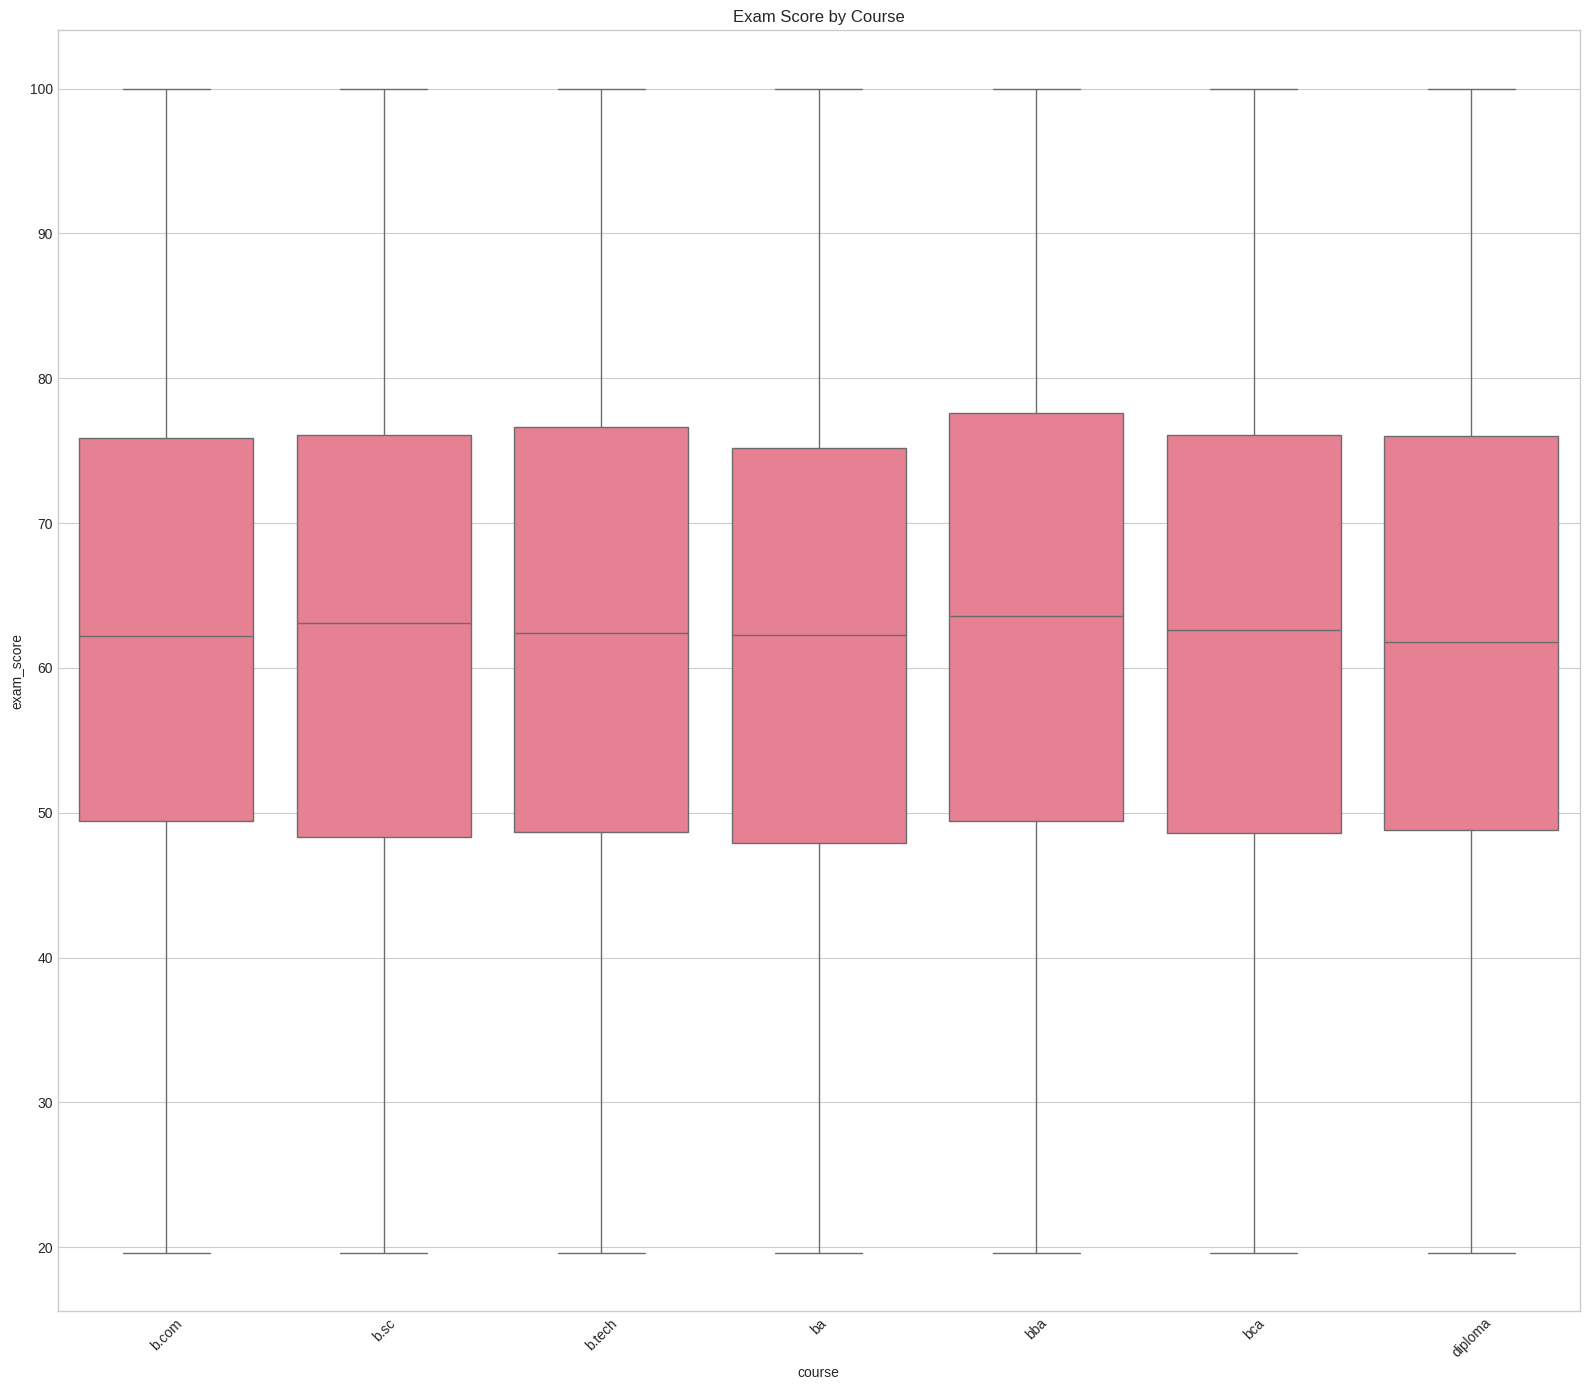

In [17]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='course', y='exam_score', ax=ax)
ax.set_title('Exam Score by Course', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
summary = (
    train_df.groupby("course")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

              n       mean  median        std    q1    q3
course                                                   
b.com    110932  62.537726    62.2  18.404936  49.4  75.9
b.sc     111554  62.295491    63.1  19.297236  48.3  76.1
b.tech   131236  62.519707    62.4  18.862381  48.7  76.6
ba        61989  61.886931    62.3  18.765944  47.9  75.2
bba       75644  63.232038    63.6  19.159462  49.4  77.6
bca       88721  62.586227    62.6  18.921838  48.6  76.1
diploma   49924  62.404354    61.8  19.094986  48.8  76.0


In [19]:
df = train_df.dropna(subset=["exam_score", "course"]).copy()

model = smf.ols("exam_score ~ C(course)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

ss_between = anova_table.loc["C(course)", "sum_sq"]
ss_resid = anova_table.loc["Residual", "sum_sq"]
ss_total = ss_between + ss_resid
eta_sq = ss_between / ss_total

In [20]:
print(anova_table)
print(f"\nEta-squared (η^2): {eta_sq:.6f}")

                 sum_sq        df          F        PR(>F)
C(course)  6.979767e+04       6.0  32.517776  2.117286e-39
Residual   2.253744e+08  629993.0        NaN           NaN

Eta-squared (η^2): 0.000310


- **ANOVA result:** (F(`6`, `629,993`)=`32.52`), (`p`~ `2.1e-39`).
  - With a sample this large, **at least one course group mean differs from another** in a statistically detectable way.
- **Effect size (η^2 = 0.000310):**
  - eta^2 is the **proportion of total variation in exam scores explained by course**.
  - eta^2 = 0.000310 ~ 0.0310%

So **course explains about 0.031% of the variance** in exam scores - essentially none in practical terms.

Even though the p-value is tiny (because we have ~630k rows), **course is not meaningfully related to exam score** in terms of how much it helps explain or predict scores. Any differences in course-level means exist, but they are **very small relative to the overall spread of scores**. Given the negligible η², any statistically significant pairwise differences between specific course categories are expected to be very small; interpret with effect sizes (e.g., Hedges’ g) rather than p-values alone.

### Exam score by Internet Access

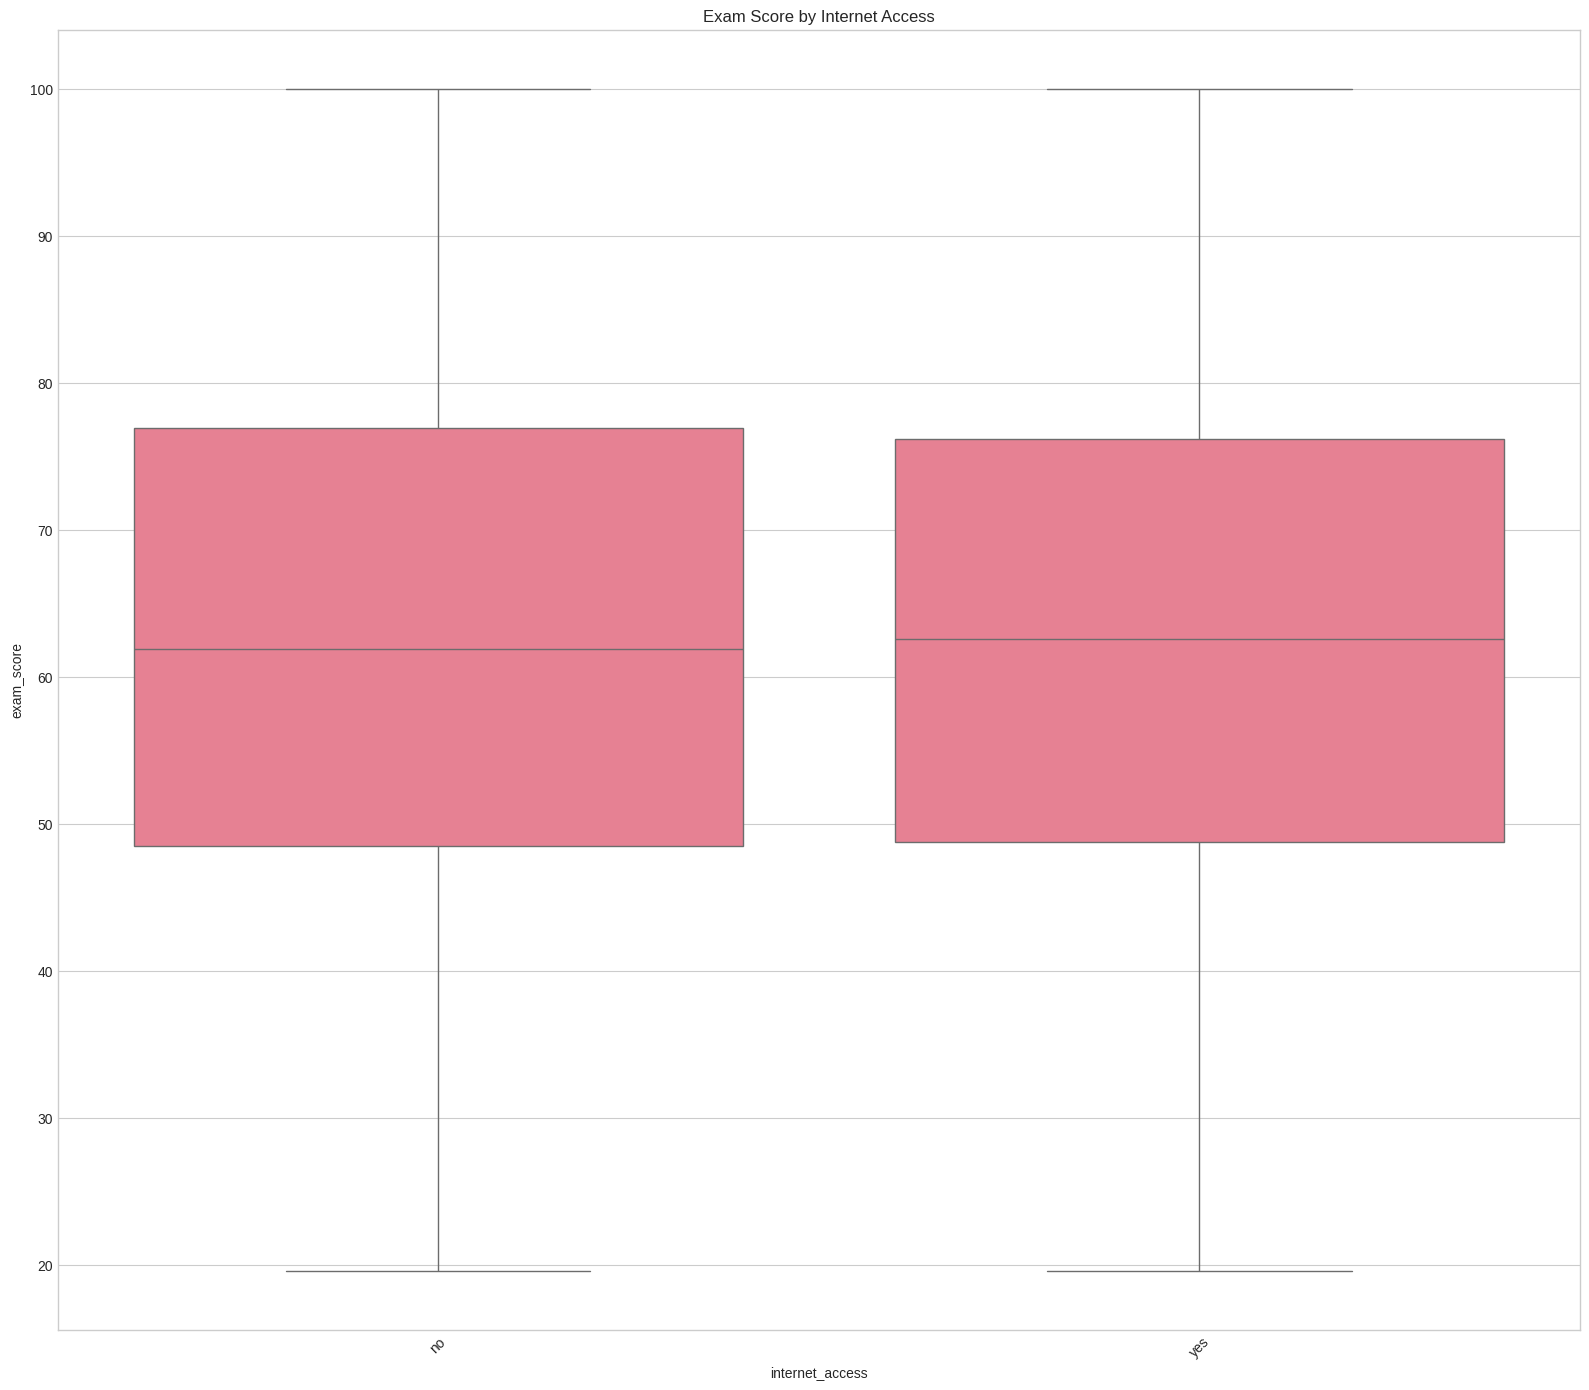

In [21]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='internet_access', y='exam_score', ax=ax)
ax.set_title('Exam Score by Internet Access', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [22]:
summary = (
    train_df.groupby("internet_access")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

                      n       mean  median        std    q1    q3
internet_access                                                  
no                50577  62.478038    61.9  19.277820  48.5  77.0
yes              579423  62.509172    62.6  18.885066  48.8  76.2


In [23]:
internet_access_yes = train_df[train_df["internet_access"]=="yes"]["exam_score"].to_numpy()
internet_access_no = train_df[train_df["internet_access"]=="no"]["exam_score"].to_numpy()

print(f"Cohen's D: {cohend(internet_access_yes, internet_access_no):.6f}")

Cohen's D: 0.001646


#### Cohen's D interpretation

**Intuition**
- d = 0: the group averages are the same.
- d = 1: the averages are one standard deviation apart (that’s pretty noticeable).
- d = 0.5: half a standard deviation apart (moderate).
- d = 0.2: small difference.

**Common rule-of-thumb (very rough)**
- 0.2 = small
- 0.5 = medium
- 0.8 = large

With **exam score** as the outcome:

- Mean (no internet) = **62.48**
- Mean (yes internet) = **62.51**
- Difference = **~0.03 points**
- **Cohen’s d = 0.0016** = **basically zero effect**

Students with and without internet access scored **about the same** on the exam.

### Exam Score vs Sleep Quality

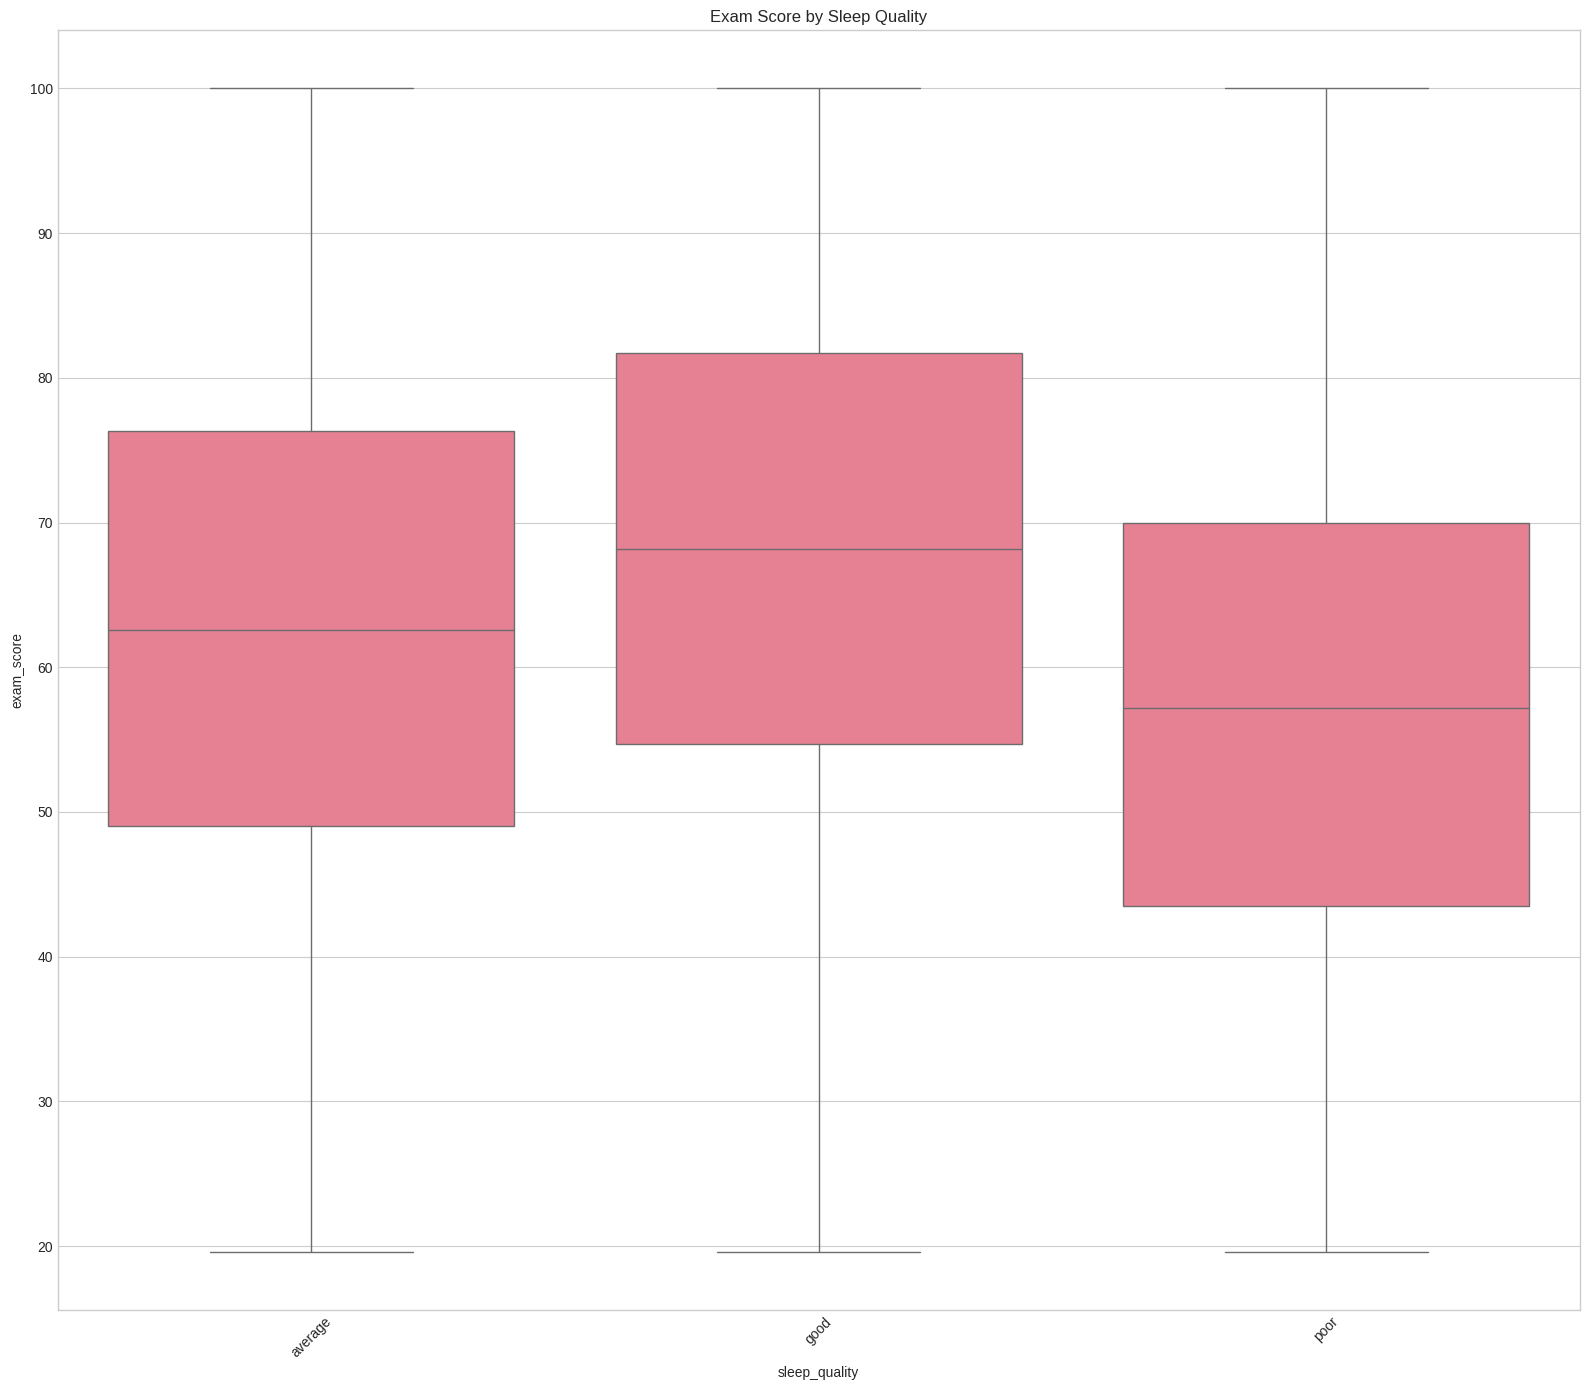

In [24]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='sleep_quality', y='exam_score', ax=ax)
ax.set_title('Exam Score by Sleep Quality', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [25]:
summary = (
    train_df.groupby("sleep_quality")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

                    n       mean  median        std    q1    q3
sleep_quality                                                  
average        203236  62.662000    62.6  18.601369  49.0  76.3
good           213089  67.884885    68.2  18.117352  54.7  81.7
poor           213675  56.995470    57.2  18.422746  43.5  70.0


### Exam Score vs study method

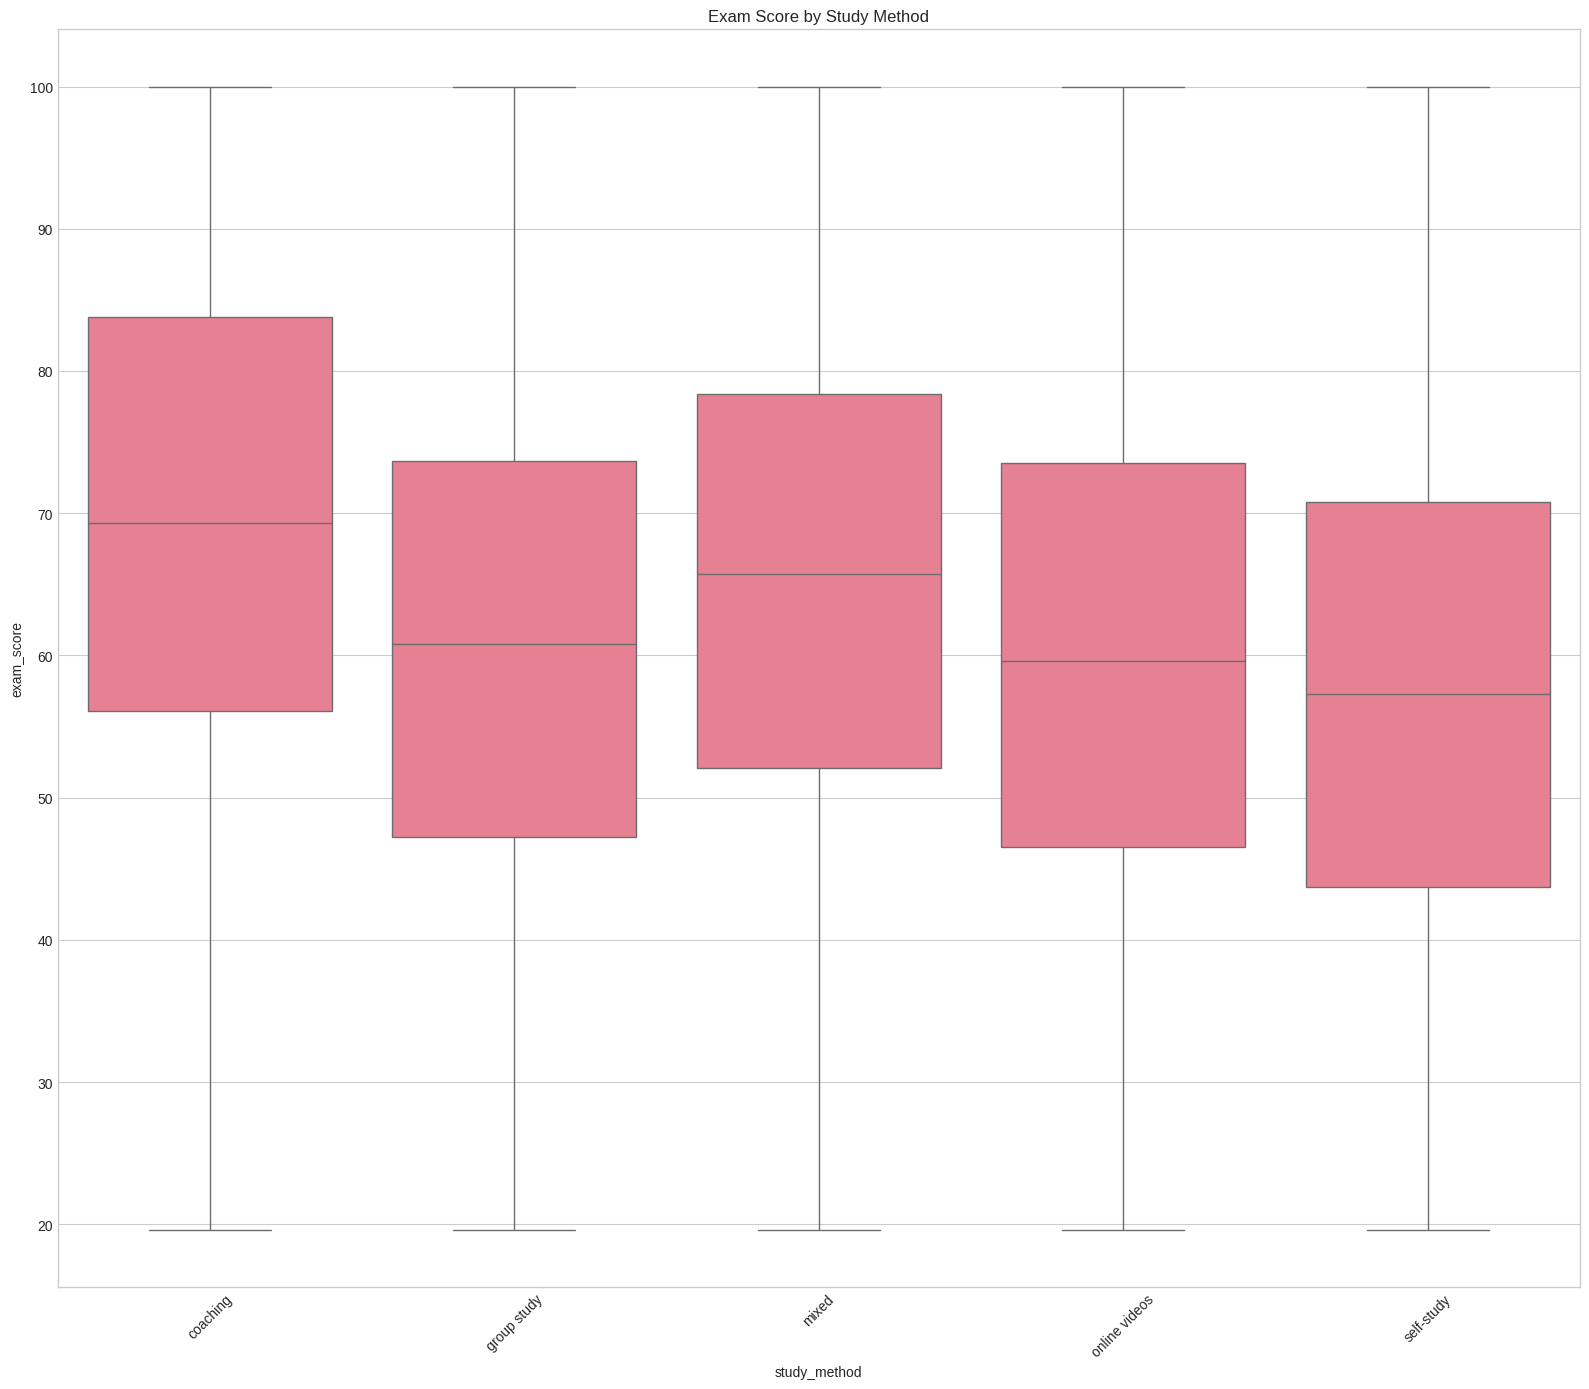

In [26]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='study_method', y='exam_score', ax=ax)
ax.set_title('Exam Score by Study Method', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
summary = (
    train_df.groupby("study_method")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

                    n       mean  median        std    q1    q3
study_method                                                   
coaching       131697  69.266665    69.3  18.446089  56.1  83.8
group study    123009  60.531838    60.8  18.219917  47.2  73.7
mixed          123086  65.101735    65.7  18.218035  52.1  78.4
online videos  121077  59.727607    59.6  18.729355  46.5  73.5
self-study     131131  57.700155    57.3  18.562730  43.7  70.8


In [28]:
df = train_df.dropna(subset=["exam_score", "study_method"]).copy()

model = smf.ols("exam_score ~ C(study_method)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

ss_between = anova_table.loc["C(study_method)", "sum_sq"]
ss_resid = anova_table.loc["Residual", "sum_sq"]
ss_total = ss_between + ss_resid
eta_sq = ss_between / ss_total

In [29]:
print(anova_table)
print(f"\nEta-squared (η²): {eta_sq:.6f}")

                       sum_sq        df            F  PR(>F)
C(study_method)  1.129143e+07       4.0  8304.288536     0.0
Residual         2.141528e+08  629995.0          NaN     NaN

Eta-squared (η²): 0.050085


- **ANOVA result:** (F(`4`, `629,995`)=`8304.29`), (`p` ~ `0.0`).
  - With a sample this large, **at least one study method group mean differs from another** in a statistically detectable way.
- **Effect size (η² = 0.050085):**
  - eta^2 is the **proportion of total variation in exam scores explained by study_method**.
  - eta^2 = 0.050085 ~ 5.01%

So **study_method explains about 5.0% of the variance** in exam scores - a **meaningful** relationship (small-to-moderate).

Unlike gender/course (where η² was near zero), here the differences are also obvious in the group means:
- coaching: **69.27**
- mixed: **65.10**
- group study: **60.53**
- online videos: **59.73**
- self-study: **57.70**

That’s roughly an **~11.6 point spread** from coaching to self-study, which is large relative to the within-group SDs (~18–19). This is why the effect size is non-negligible.

### Exam SCore by facility rating

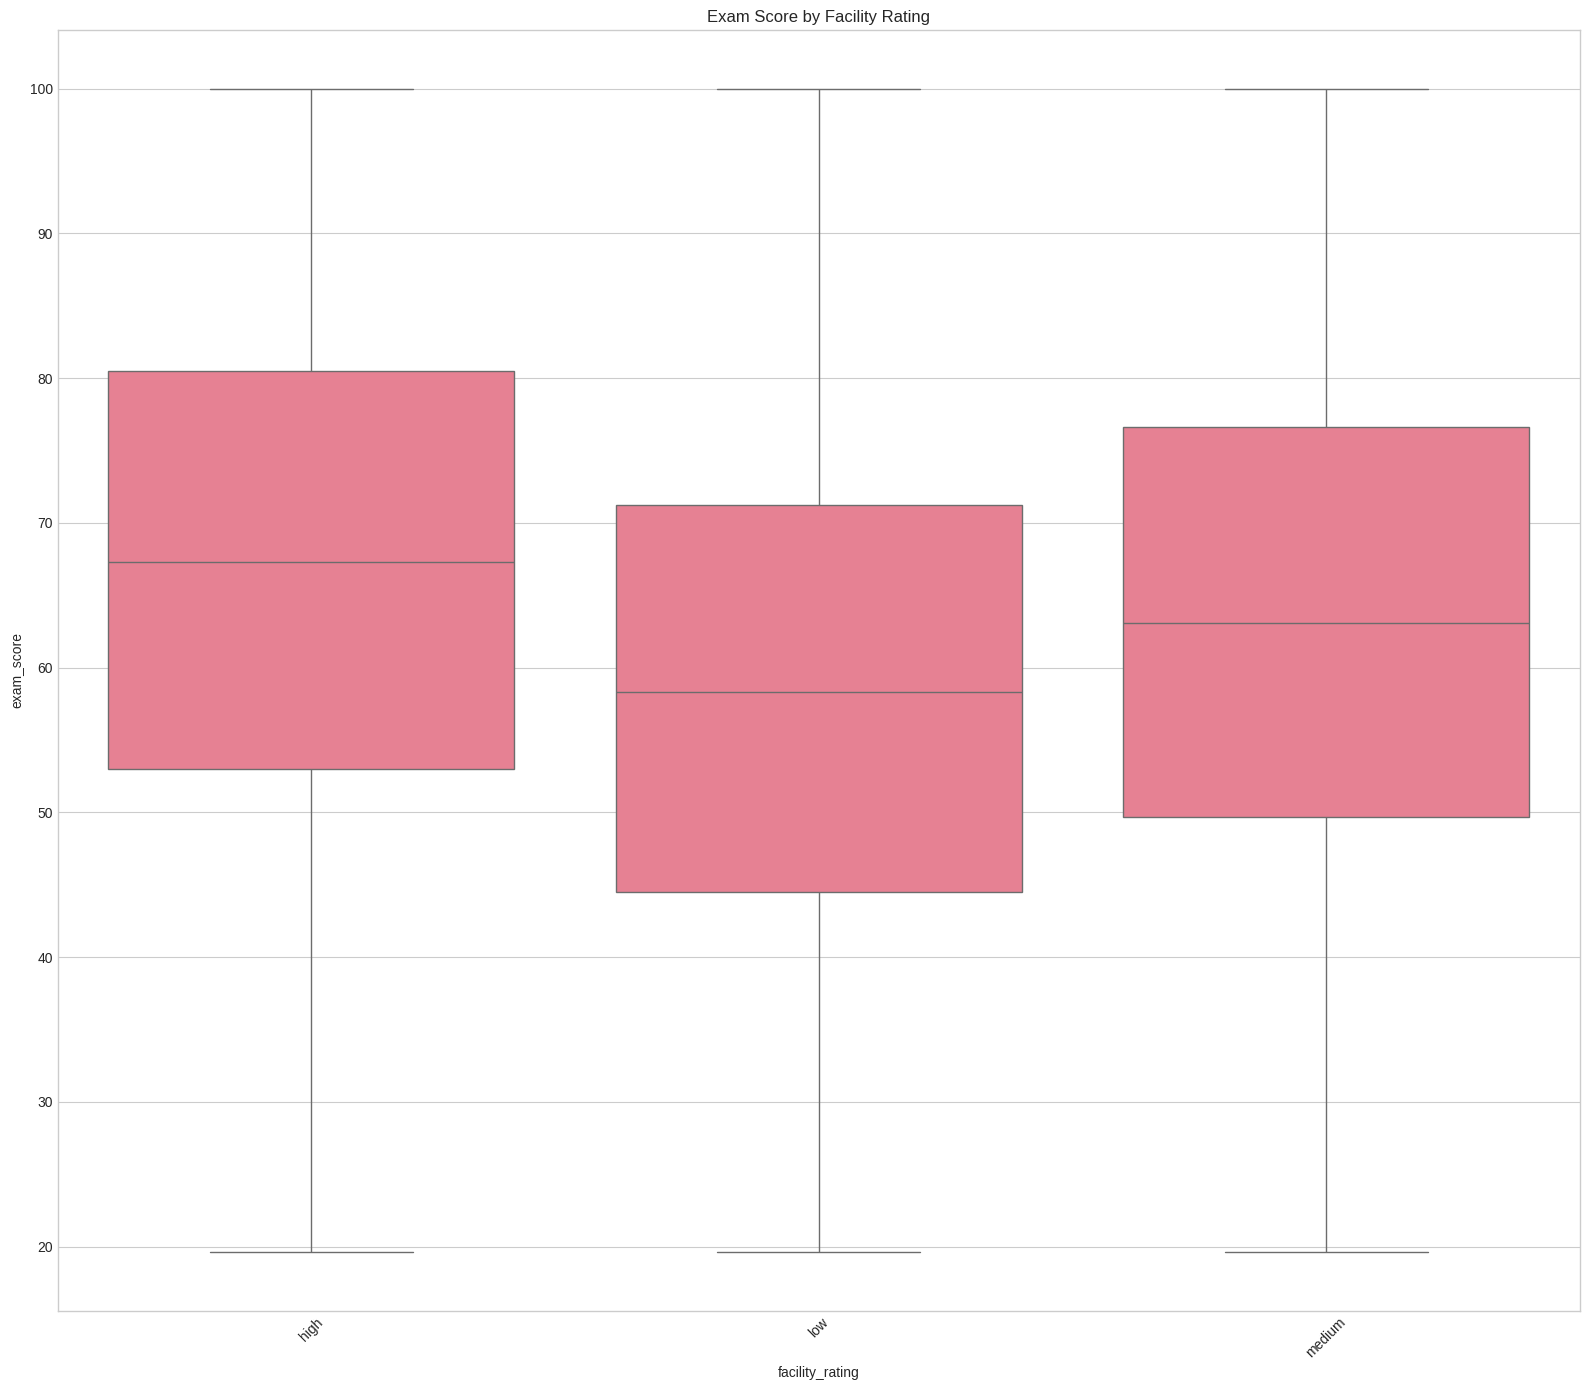

In [30]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='facility_rating', y='exam_score', ax=ax)
ax.set_title('Exam Score by Facility Rating', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [31]:
summary = (
    train_df.groupby("facility_rating")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

                      n       mean  median        std    q1    q3
facility_rating                                                  
high             203540  66.707126    67.3  18.525910  53.0  80.5
low              212378  57.954546    58.3  18.563344  44.5  71.2
medium           214082  63.028954    63.1  18.636271  49.7  76.6


In [32]:
df = train_df.dropna(subset=["exam_score", "facility_rating"]).copy()

model = smf.ols("exam_score ~ C(facility_rating)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

ss_between = anova_table.loc["C(facility_rating)", "sum_sq"]
ss_resid = anova_table.loc["Residual", "sum_sq"]
ss_total = ss_between + ss_resid
eta_sq = ss_between / ss_total

In [33]:
print(anova_table)
print(f"\nEta-squared (η²): {eta_sq:.6f}")

                          sum_sq        df             F  PR(>F)
C(facility_rating)  8.050484e+06       2.0  11664.965996     0.0
Residual            2.173937e+08  629997.0           NaN     NaN

Eta-squared (η²): 0.035709


- **ANOVA result:** (F(`2`, `629,997`)=`11664.97`), (`p` ~ `0.0`).
  - With a sample this large, **at least one facility_rating group mean differs from another** in a statistically detectable way.
- **Effect size (η² = 0.035709):**
  - eta^2 is the **proportion of total variation in exam scores explained by facility_rating**.
  - eta^2 = 0.035709 ~ 3.57%

So **facility_rating explains about 3.6% of the variance** in exam scores - a **meaningful** relationship (small-to-moderate).

The group means show clear practical separation:
- **high:** 66.71  
- **medium:** 63.03  
- **low:** 57.95  

That’s an **~8.75 point** difference between high vs low, which is sizeable relative to the within-group SDs (~18.5–18.6), consistent with the non-negligible η².

### Exam Score by Exam Difficulty

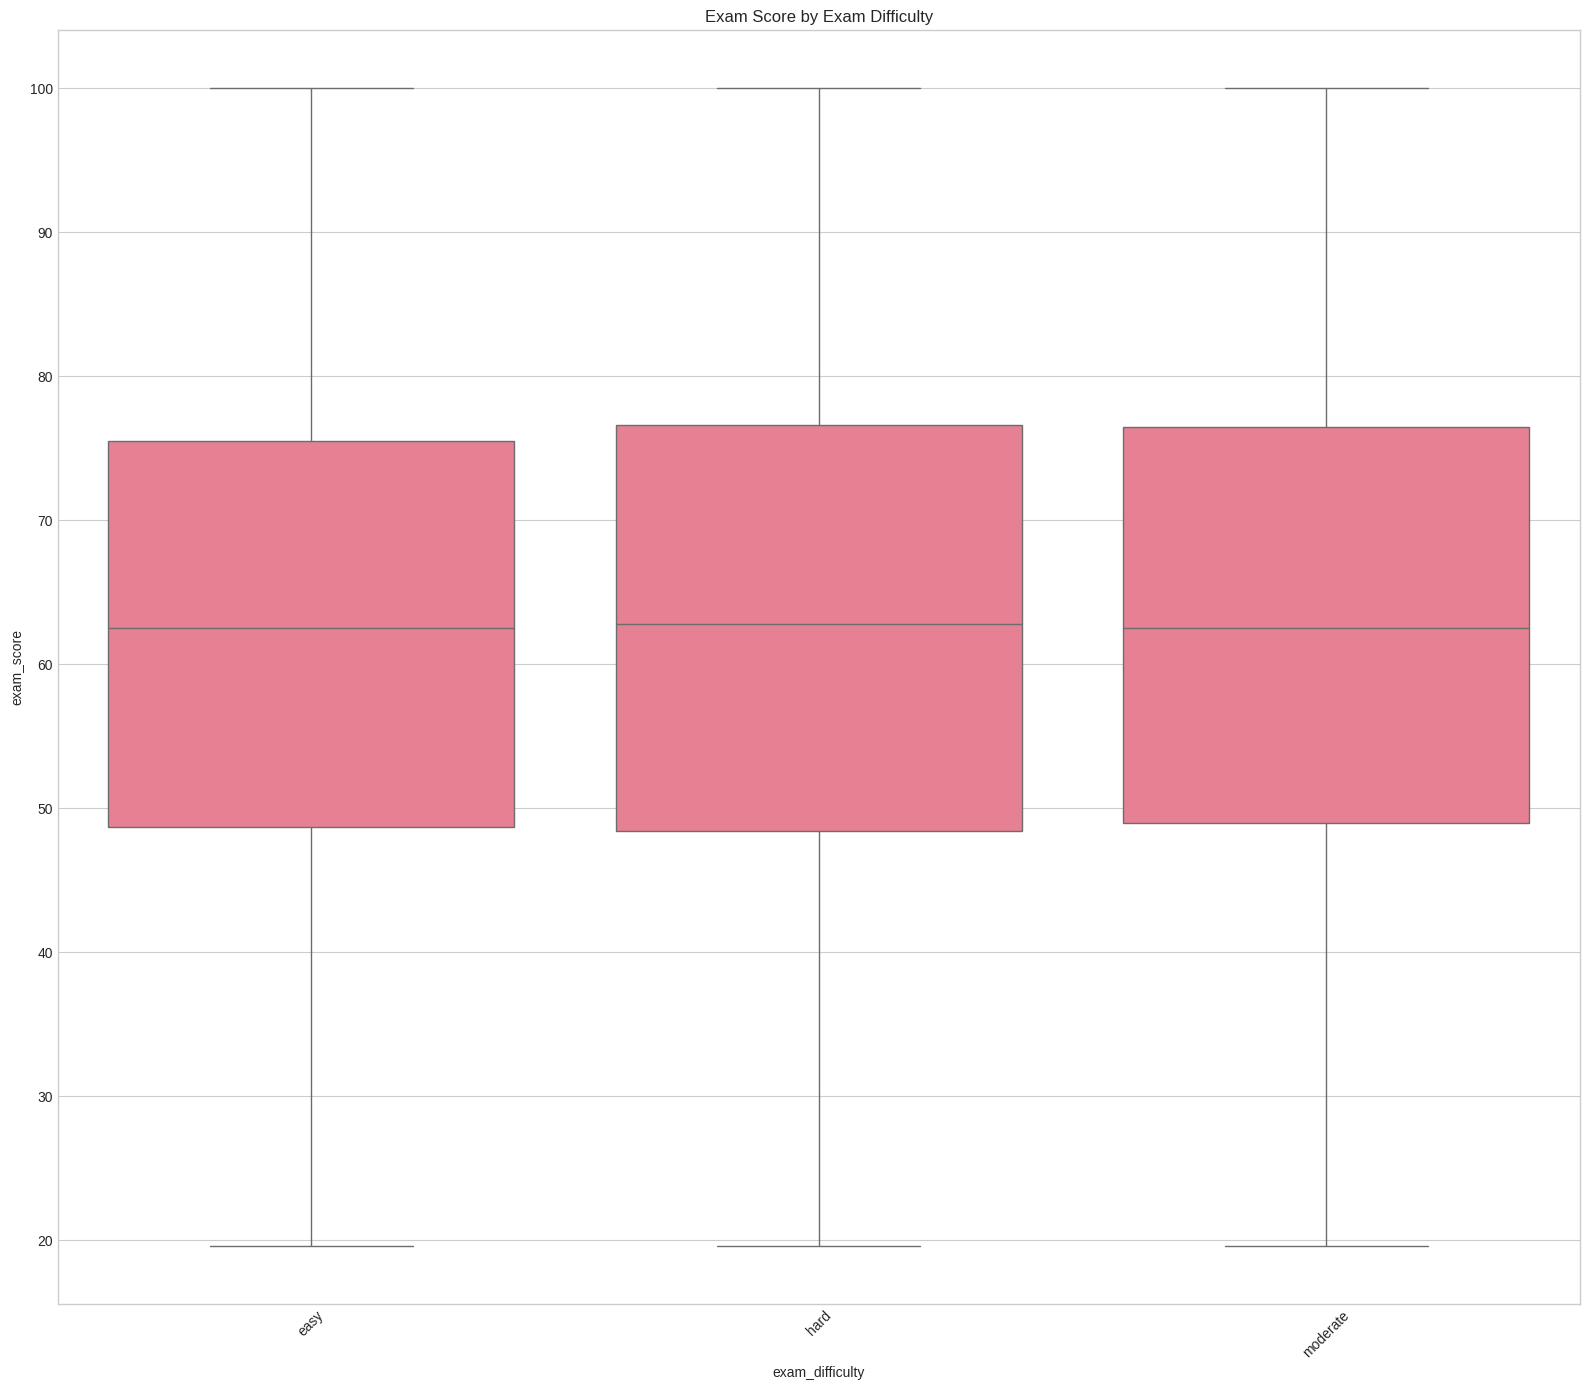

In [34]:
fig, ax = plt.subplots(figsize=(16, 14))

sns.boxplot(data=train_df, x='exam_difficulty', y='exam_score', ax=ax)
ax.set_title('Exam Score by Exam Difficulty', fontsize=12)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [35]:
summary = (
    train_df.groupby("exam_difficulty")["exam_score"]
            .agg(
                n="count",
                mean="mean",
                median="median",
                std="std",
                q1=lambda s: s.quantile(0.25),
                q3=lambda s: s.quantile(0.75)
            )
)

print(summary)

                      n       mean  median        std    q1    q3
exam_difficulty                                                  
easy             176540  62.214401    62.5  18.708772  48.7  75.5
hard              99478  62.671693    62.8  19.136236  48.4  76.6
moderate         353982  62.606060    62.5  18.956526  49.0  76.5


In [36]:
df = train_df.dropna(subset=["exam_score", "exam_difficulty"]).copy()

model = smf.ols("exam_score ~ C(exam_difficulty)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

ss_between = anova_table.loc["C(exam_difficulty)", "sum_sq"]
ss_resid = anova_table.loc["Residual", "sum_sq"]
ss_total = ss_between + ss_resid
eta_sq = ss_between / ss_total

In [37]:
print(anova_table)
print(f"\nEta-squared (η²): {eta_sq:.6f}")

                          sum_sq        df          F        PR(>F)
C(exam_difficulty)  2.128610e+04       2.0  29.744487  1.209882e-13
Residual            2.254229e+08  629997.0        NaN           NaN

Eta-squared (η²): 0.000094


- **ANOVA result:** (F(`2`, `629,997`)=`29.74`), (`p`~ `1.21e-13`).
  - With a sample this large, **at least one exam_difficulty group mean differs from another** in a statistically detectable way.
- **Effect size (η² = 0.000094):**
  - eta^2 is the **proportion of total variation in exam scores explained by exam_difficulty**.
  - eta^2 = 0.000094 ~ 0.0094%

So **exam_difficulty explains about 0.009% of the variance** in exam scores - essentially none in practical terms.

The group means are nearly identical:
- **easy:** 62.21  
- **moderate:** 62.61  
- **hard:** 62.67  

The largest gap (hard vs easy) is only **~0.46 points**, which is tiny relative to the within-group SDs (~19). That’s why the p-value is very small (huge N), but the effect size is negligible.

## Numerical Feature Analysis

| Column           | Data Type |
|------------------|-----------|
| age              | int64     | 
| study_hours      | float64   | 
| class_attendance | float64   | 
| sleep_hours      | float64   | 
| exam_score       | float64   | 

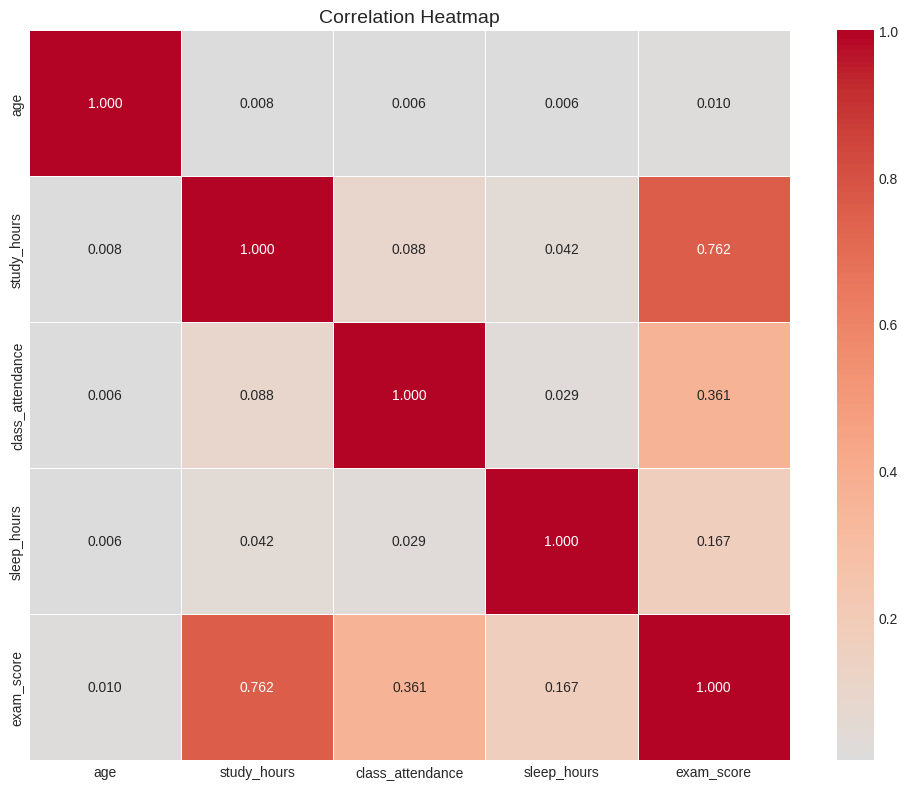

In [38]:
num_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']

plt.figure(figsize=(10, 8))
correlation = train_df[num_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.3f', linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

In [39]:
corr_string = correlation.round(3)
print(corr_string.to_string())

                    age  study_hours  class_attendance  sleep_hours  exam_score
age               1.000        0.008             0.006        0.006       0.010
study_hours       0.008        1.000             0.088        0.042       0.762
class_attendance  0.006        0.088             1.000        0.029       0.361
sleep_hours       0.006        0.042             0.029        1.000       0.167
exam_score        0.010        0.762             0.361        0.167       1.000


### Correlation summary (Pearson r)

Correlations with exam_score:
- `study_hours`: r = 0.762  (strong positive association)
- `class_attendance`: r = 0.361  (moderate positive association)
- `sleep_hours`: r = 0.167  (weak positive association)
- `age`: r = 0.010  (essentially no association)

Other notable relationships among predictors:
- `study_hours` vs `class_attendance`: r = 0.088 (very weak positive)
- `study_hours` vs `sleep_hours`: r = 0.042 (very weak positive)
- `class_attendance` vs `sleep_hours`: r = 0.029 (very weak positive)
- `age` has near-zero correlation with the other variables (|r| ~ 0.006-0.011)

Exam scores are most strongly associated with `study_hours`, with smaller (but still positive) associations for `class_attendance` and `sleep_hours`. Age appears unrelated to exam performance in this dataset. Also, the predictors are not strongly correlated with each other, so multicollinearity is unlikely to be a major concern for a basic regression model.

## Overall EDA Summary

### Dataset overview 

The training data contains **630,000 rows** and **13 columns**, with the target variable **`exam_score`** (continuous, 0-100 scale). An **`id`** column is a unique identifier (sequential from 0 to 629,999) and is not inherently predictive. The `id` column would need to be removed during feature engineering.

- **Data quality:**
  - **No missing values** across any features or the target.
  - Data types are clean and appropriate after casting:
    - **Numeric:** `age`, `study_hours`, `class_attendance`, `sleep_hours`, `exam_score`
    - **Categorical:** `gender`, `course`, `internet_access`, `sleep_quality`, `study_method`, `facility_rating`, `exam_difficulty`
- **Typical student profile (central tendency):**
  - **Age:** ~**20.55** years (median **21**, range **17-24**)
  - **Study hours:** mean ~**4.00** (median **4.00**, range **0.08-7.91**)
  - **Class attendance (%):** mean ~**71.99** (median **72.6**, range **40.6-99.4**)
  - **Sleep hours:** mean ~**7.07** (median **7.1**, range **4.1-9.9**)
  - **Exam score:** mean ~**62.51** (median **62.6**, range **19.6-100**)
- **Spread / variability:**
  - `exam_score` has **substantial variability** (std ~**18.92**), suggesting meaningful separation between low- and high-performing students.
  - `class_attendance` also varies widely (std ~**17.43**), while `age` is comparatively tight (std ~**2.26**).
- **Notable extremes & sanity checks:**
  - Very low study time values exist (down to **0.08 hours**), and attendance can be as low as **~40%**, which may represent legitimately low-engagement students rather than data issues (since missingness is zero and ranges look plausible).
  - Scores span almost the entire possible scale (**~20 to 100**), indicating no obvious clipping problems.
- **Model-readiness implications:**
  - This is a **mixed-type regression problem** with several categorical predictors that will require **encoding** (one-hot or target/ordinal encoding depending on the feature).
